# PCA Autoencoder (Part 3)

In this notebook, I will attempt to implement the hierarchical structure the authors adopted to mimic the function of PCA (see the [introduction in Part 1](pca_ae)). The trick is to use subnetworks that train one single latent code at a time (while the rest are "fixed") and stack them sequentially together to train new decoders. 

## Synthesize dataset

To test the validity of the method, I will create the set of binary ellipses with only two variables (size and axes).

### Setup

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras


np.random.seed(42)
tf.random.set_seed(42)

### Phantom binary ellipses

As in the Parts 1, image dimension is kept at (64, 64). The dataset contains 8000 samples and a batch size of 500 will be used for training.

In [ ]:
def phantomEllipse(n, a, b):
    x = np.arange(n)
    R = n // 2
    y = x[:, np.newaxis]
    img = (x-R)**2/a**2 + (y-R)**2/b**2
    img[img<=1] = 1
    img[img>1] = 0
    return img

In [ ]:
n = 64
num_batch = 16
batch_size = 500
N = int(num_batch * batch_size)
random_gen = np.random.default_rng()
a = random_gen.uniform(1, n//2, N)
b = random_gen.uniform(1, n//2, N)
dataset = np.array([phantomEllipse(n, _a, _b) for _a, _b in zip(a, b)])
dataset = dataset[..., np.newaxis]

Let's sample some images from the dataset:

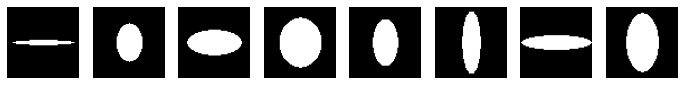

In [ ]:
frames = np.random.choice(np.arange(N), 8)
_, ax = plt.subplots(1, 8, figsize=(12, 3))
for i in range(8):
    ax[i].imshow(dataset[frames[i], ..., 0], cmap=plt.get_cmap('gray'))
    ax[i].axis("off")
plt.show()

## PCA Autoencoder with hierarchy

### Covariance loss

In [ ]:
class LatentCovarianceLayer(keras.layers.Layer):
    def __init__(self, lam=0.1, **kwargs):
        super().__init__(**kwargs)
        self.lam = lam
    def call(self, inputs):
        covariance = self.lam * tf.math.reduce_mean(tf.math.reduce_prod(inputs, 1))
        self.add_loss(tf.math.abs(covariance))
        self.add_metric(tf.math.abs(covariance), name='cov_loss')
        return inputs
    def get_config(self):
        base_config = super().get_config()
        return {**base_config, "lam":self.lam,}

### Standard autoencoder components

Since we will be reusing the same encoder and decoder architectures, I will define them as functions to be called later.

In [ ]:
def encoder_gen(inputs):
    x = keras.layers.Conv2D(4, (3, 3), padding='same')(inputs)
    x = keras.layers.LeakyReLU()(x)
    x = keras.layers.MaxPool2D((2, 2))(x)
    x = keras.layers.Conv2D(8, (3, 3), padding='same')(x)
    x = keras.layers.LeakyReLU()(x)
    x = keras.layers.MaxPool2D((2, 2))(x)
    x = keras.layers.Conv2D(16, (3, 3), padding='same')(x)
    x = keras.layers.LeakyReLU()(x)
    x = keras.layers.MaxPool2D((2, 2))(x)
    x = keras.layers.Conv2D(32, (3, 3), padding='same')(x)
    x = keras.layers.LeakyReLU()(x)
    x = keras.layers.MaxPool2D((2, 2))(x)
    x = keras.layers.Conv2D(64, (3, 3), padding='same')(x)
    x = keras.layers.LeakyReLU()(x)
    x = keras.layers.MaxPool2D((2, 2))(x)
    x = keras.layers.Flatten()(x)
    x = keras.layers.Dense(1)(x)
    x = keras.layers.LeakyReLU()(x)

    return x

def decoder_gen(inputs):
    x = keras.layers.Dense(16)(inputs)
    x = keras.layers.LeakyReLU()(x)
    x = keras.layers.Reshape((2, 2, 4))(x)
    x = keras.layers.Conv2DTranspose(32, (3, 3), strides=2, padding='same')(x)
    x = keras.layers.LeakyReLU()(x)
    x = keras.layers.Conv2DTranspose(16, (3, 3), strides=2, padding='same')(x)
    x = keras.layers.LeakyReLU()(x)
    x = keras.layers.Conv2DTranspose(8, (3, 3), strides=2, padding='same')(x)
    x = keras.layers.LeakyReLU()(x)
    x = keras.layers.Conv2DTranspose(4, (3, 3), strides=2, padding='same')(x)
    x = keras.layers.LeakyReLU()(x)
    x = keras.layers.Conv2DTranspose(1, (3, 3), strides=2, padding='same')(x)

    return x

## Autonencoder 1

The first autoencoder has just one latent code and doesn't have any additional loss terms.

In [ ]:
# SCROLL
keras.backend.clear_session()
input_img = keras.layers.Input(shape=[64, 64, 1])
encoded = encoder_gen(input_img)
decoded = decoder_gen(encoded)
pca_ae = keras.models.Model(input_img, decoded)

optimizer = tf.keras.optimizers.Adam(learning_rate=0.002)
pca_ae.compile(optimizer=optimizer, loss='mse')

tempfn='./model_0.hdf5'
model_cb=keras.callbacks.ModelCheckpoint(tempfn, monitor='loss',save_best_only=True, verbose=1)
early_cb=keras.callbacks.EarlyStopping(monitor='loss', patience=50, verbose=1)
learning_rate_reduction = keras.callbacks.ReduceLROnPlateau(monitor='loss',
                                                            patience=25,
                                                            verbose=1,
                                                            factor=0.5,
                                                            min_lr=0.00001)
cb = [model_cb, early_cb, learning_rate_reduction]

history=pca_ae.fit(dataset, dataset,
                   epochs=1000,
                   batch_size=500,
                   shuffle=True,
                   callbacks=cb)

Epoch 1/1000
16/16 [==============================] - 32s 27ms/step - loss: 0.1991

Epoch 00001: loss improved from inf to 0.19909, saving model to ./model_0.hdf5
Epoch 2/1000
16/16 [==============================] - 0s 26ms/step - loss: 0.1710

Epoch 00002: loss improved from 0.19909 to 0.17097, saving model to ./model_0.hdf5
Epoch 3/1000
16/16 [==============================] - 0s 28ms/step - loss: 0.1192

Epoch 00003: loss improved from 0.17097 to 0.11918, saving model to ./model_0.hdf5
Epoch 4/1000
16/16 [==============================] - 0s 27ms/step - loss: 0.0789

Epoch 00004: loss improved from 0.11918 to 0.07888, saving model to ./model_0.hdf5
Epoch 5/1000
16/16 [==============================] - 0s 27ms/step - loss: 0.0695

Epoch 00005: loss improved from 0.07888 to 0.06947, saving model to ./model_0.hdf5
Epoch 6/1000
16/16 [==============================] - 0s 27ms/step - loss: 0.0665

Epoch 00006: loss improved from 0.06947 to 0.06646, saving model to ./model_0.hdf5
Epoch 7

### Examine the results

Let's load the best model and test it on a frame first.

In [ ]:
model_0 = keras.models.load_model('model_0.hdf5')

In [ ]:
model_0.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 64, 64, 1)]       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 64, 64, 4)         40        
_________________________________________________________________
leaky_re_lu (LeakyReLU)      (None, 64, 64, 4)         0         
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 32, 32, 4)         0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 32, 32, 8)         296       
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 32, 32, 8)         0         
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 16, 16, 8)         0     

I encountered an issue when I tried to save the second autoencoder model in HDF5 format (as the first autoencoder is used and may use the same namestrings for similar layers). The function below prepends a string to all the namestrings in the model (layers and weights).

In [ ]:
def edit_name(model, name):
  for layer in model.layers:
      layer._name = name + '_' + layer._name 
  for i in range(len(model.weights)):
      model.weights[i]._handle_name = name + '_' + model.weights[i].name

In [ ]:
edit_name(model_0, 'model_0')

In [ ]:
model_0.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
model_0_input_1 (InputLayer) [(None, 64, 64, 1)]       0         
_________________________________________________________________
model_0_conv2d (Conv2D)      (None, 64, 64, 4)         40        
_________________________________________________________________
model_0_leaky_re_lu (LeakyRe (None, 64, 64, 4)         0         
_________________________________________________________________
model_0_max_pooling2d (MaxPo (None, 32, 32, 4)         0         
_________________________________________________________________
model_0_conv2d_1 (Conv2D)    (None, 32, 32, 8)         296       
_________________________________________________________________
model_0_leaky_re_lu_1 (Leaky (None, 32, 32, 8)         0         
_________________________________________________________________
model_0_max_pooling2d_1 (Max (None, 16, 16, 8)         0     

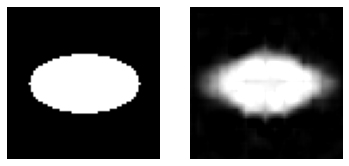

In [ ]:
img = dataset[1430, ...]
img_rec = model_0(img[np.newaxis,...])
_, ax = plt.subplots(1, 2)
ax[0].imshow(img[...,0], cmap=plt.get_cmap('gray'), vmin=0, vmax=1)
ax[0].axis('off')
ax[1].imshow(img_rec[0,...,0], cmap=plt.get_cmap('gray'), vmin=0, vmax=1)
ax[1].axis('off')
plt.show()

We can see that the first autoencoder with just a single latent code couldn't really reconstruct the input image that well.

### Extract encoder and decoder

There are different methods to construct models based on layers from an existing/pretrained model. Here I use `Sequential` as both the encoder and decoder are sequential for the first autoencoder.


In [ ]:
decoder_0 = keras.models.Sequential(model_0.layers[-12:])
encoder_0 = keras.models.Sequential(model_0.layers[:-12])

Double check that the encoder and decoder can reproduce the result of the entire autoencoder. Essentially, we use the encoder to encode an image and use the decoder to decode the latent code.

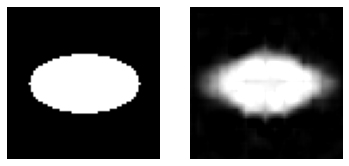

In [ ]:
data = encoder_0(img[np.newaxis,...])
_img = decoder_0(data)
_, ax = plt.subplots(1, 2)
ax[0].imshow(img[...,0], cmap=plt.get_cmap('gray'), vmin=0, vmax=1)
ax[0].axis('off')
ax[1].imshow(_img[0,...,0], cmap=plt.get_cmap('gray'), vmin=0, vmax=1)
ax[1].axis('off')
plt.show()

It works as expected. We could also check how the latent code behaves over a range of values.

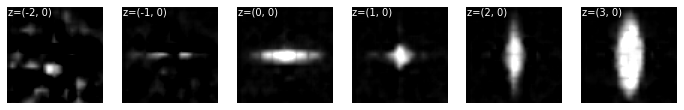

In [ ]:
vals = [-2, -1, 0, 1, 2, 3]
_, ax = plt.subplots(1, len(vals), figsize=(12, 3))
for i in range(len(vals)):
    img_dec = decoder_0.predict([vals[i]])
    ax[i].imshow(img_dec[0,...,0], cmap=plt.get_cmap('gray'), vmin=0, vmax=1)
    ax[i].axis("off")
    ax[i].text(0, 5, f"z=({vals[i]}, 0)", c='w')
plt.show()

As expected, the single latent code now contains both features of the dataset (size and axes). Next, we will reuse this trained encoder in the second autoencoder.

## Autoencoder 2

For the second autoencoder, the encoder is also used to train a single latent code. This code will be concatenated with the code from the first trained encoder to form a new latent space of the size of 2. We need to ensure that:

- The parameters of the first (pretrained) encoder are fixed (not trainable)
- A batch normalization layer is added after the new latent space to remove the batch mean term in the covariance loss
- The custom covariance loss layer is added to account for the rest of the covariance loss

In [ ]:
keras.backend.clear_session()
encoder_0.trainable = False
input_img = keras.layers.Input(shape=[64, 64, 1])
encoded_1 = encoder_gen(input_img)
encoded_0 = encoder_0(input_img)
concat = keras.layers.Concatenate()([encoded_0, encoded_1])
batchnorm = keras.layers.BatchNormalization(center=False, scale=False)(concat)
add_loss = LatentCovarianceLayer(1)(batchnorm)
decoded_1 = decoder_gen(add_loss)
pca_ae = keras.models.Model(input_img, decoded_1)

In [ ]:
pca_ae.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 64, 64, 1)]  0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 64, 64, 4)    40          input_1[0][0]                    
__________________________________________________________________________________________________
leaky_re_lu (LeakyReLU)         (None, 64, 64, 4)    0           conv2d[0][0]                     
__________________________________________________________________________________________________
max_pooling2d (MaxPooling2D)    (None, 32, 32, 4)    0           leaky_re_lu[0][0]                
______________________________________________________________________________________________

We can see that all the parameters from the first autoencoder (sequantial_1) are fixed.

### Train the model

In [ ]:
# SCROLL
optimizer = tf.keras.optimizers.Adam(learning_rate=0.002)
pca_ae.compile(optimizer=optimizer, loss='mse')

tempfn='./model_1.hdf5'
model_cb=keras.callbacks.ModelCheckpoint(tempfn, monitor='loss',save_best_only=True, verbose=1)
early_cb=keras.callbacks.EarlyStopping(monitor='loss', patience=50, verbose=1)
learning_rate_reduction = keras.callbacks.ReduceLROnPlateau(monitor='loss',
                                                            patience=25,
                                                            verbose=1,
                                                            factor=0.5,
                                                            min_lr=0.00001)
cb = [model_cb, early_cb, learning_rate_reduction]

history=pca_ae.fit(dataset, dataset,
                   epochs=1000,
                   batch_size=500,
                   shuffle=True,
                   callbacks=cb)

Epoch 1/1000
16/16 [==============================] - 2s 35ms/step - loss: 0.4824 - cov_loss: 0.2873

Epoch 00001: loss improved from inf to 0.48241, saving model to ./model_1.hdf5
Epoch 2/1000
16/16 [==============================] - 0s 30ms/step - loss: 0.2257 - cov_loss: 0.0711

Epoch 00002: loss improved from 0.48241 to 0.22572, saving model to ./model_1.hdf5
Epoch 3/1000
16/16 [==============================] - 0s 30ms/step - loss: 0.1401 - cov_loss: 0.0318

Epoch 00003: loss improved from 0.22572 to 0.14012, saving model to ./model_1.hdf5
Epoch 4/1000
16/16 [==============================] - 0s 30ms/step - loss: 0.1292 - cov_loss: 0.0520

Epoch 00004: loss improved from 0.14012 to 0.12925, saving model to ./model_1.hdf5
Epoch 5/1000
16/16 [==============================] - 0s 30ms/step - loss: 0.0920 - cov_loss: 0.0288

Epoch 00005: loss improved from 0.12925 to 0.09201, saving model to ./model_1.hdf5
Epoch 6/1000
16/16 [==============================] - 0s 31ms/step - loss: 0.06

### Examine the results

In [ ]:
model_1 = keras.models.load_model('model_1.hdf5', custom_objects={"LatentCovarianceLayer": LatentCovarianceLayer})

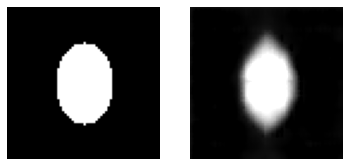

In [ ]:
img = dataset[2430, ...]
img_rec = model_1.predict(img[np.newaxis,...])
_, ax = plt.subplots(1, 2)
ax[0].imshow(img[...,0], cmap=plt.get_cmap('gray'), vmin=0, vmax=1)
ax[0].axis('off')
ax[1].imshow(img_rec[0,...,0], cmap=plt.get_cmap('gray'), vmin=0, vmax=1)
ax[1].axis('off')
plt.show()

We can see that the new autoencoder does a better job at reconstructing the input image. Now we can check how well the latent space can separate the features.

In [ ]:
pca_ae_decoder = keras.models.Sequential(model_1.layers[-12:])

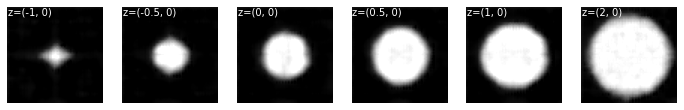

In [ ]:
vals = [-1, -0.5, 0, 0.5, 1, 2]
_, ax = plt.subplots(1, len(vals), figsize=(12, 3))
for i in range(len(vals)):
    img_dec = pca_ae_decoder.predict([[vals[i], 0]])
    ax[i].imshow(img_dec[0,...,0], cmap=plt.get_cmap('gray'), vmin=0, vmax=1)
    ax[i].axis("off")
    ax[i].text(0, 5, f"z=({vals[i]}, 0)", c='w')
plt.show()


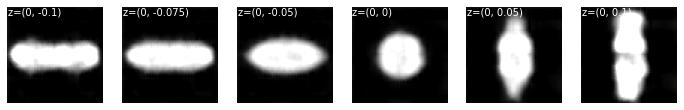

In [ ]:
vals = [-0.1, -0.075, -0.05, 0, 0.05, 0.1]
_, ax = plt.subplots(1, len(vals), figsize=(12, 3))
for i in range(len(vals)):
    img_dec = pca_ae_decoder.predict([[0, vals[i]]])
    ax[i].imshow(img_dec[0,...,0], cmap=plt.get_cmap('gray'), vmin=0, vmax=1)
    ax[i].axis("off")
    ax[i].text(0, 5, f"z=(0, {vals[i]})", c='w')
plt.show()

It is clear that the hierarchical method works as intended. It's interesting to observe that the latent code controlling the size of the ellipse is the more prominent code (based on its magnitude), which comes from the first autoencoder. Although the second code is much "weaker" in comparison, it controls the important feature of the orientation of the ellipses (either horizontal or vertical). The hierarchical nature of PCA is thus emulated with the bonus of nonlinearity. However, for this specific dataset, the hierarchy may not be entirely necessary, as demonstrated in [Part 1](pca_ae). For the sake of consistency, the structures of the encoder and decoder are kept the same. Better results (smaller loss) can be expected with deeper networks and larger dataset.